# Assignment 1: k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [1]:
# Load required packages and dataset. Do not modify.
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()


## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


The dataset contains data on three Iris species (Iris setosa, Iris versicolor and Iris virginica). The input features are the length and width of the sepal and the petal. To be specific, the columns contain the following order of these sizes: sepal length, sepal width, petal length, petal width. The goal of the provided dataset is to distinguish the three Iris species based on the given features. Therefore, the classification target is the corresponding flower species, which has to be determined.

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [2]:
# number of samples in general
n_samples = len(X)

# number of samples per flower class
iris_type, n_samples_iris = np.unique(y, return_counts=True)
idx_iris1 = np.arange(n_samples_iris[0])
idx_iris2 = np.arange(n_samples_iris[0], n_samples_iris[0]+n_samples_iris[1])
idx_iris3 = np.arange(n_samples_iris[0]+n_samples_iris[1], n_samples_iris[0]+n_samples_iris[1]+n_samples_iris[2])

# mean value and standard deviation for each of the four input features
# initialize arrays which contain the input features
# array is sorted with the flower types defined in y in the according order [0 1 2] for the mean and std values
sepal_length = [X[idx_iris1,0], X[idx_iris2,0], X[idx_iris3,0]]
sepal_width = [X[idx_iris1,1], X[idx_iris2,1], X[idx_iris3,1]]
petal_length = [X[idx_iris1,2], X[idx_iris2,2], X[idx_iris3,2]]
petal_width = [X[idx_iris1,3], X[idx_iris2,3], X[idx_iris3,3]]

# mean and std arrays per flower type [0 1 2]
mean_petalL = np.mean(petal_length, axis=1)
mean_petalW = np.mean(petal_width, axis=1)
mean_sepalL = np.mean(sepal_length, axis=1)
mean_sepalW = np.mean(sepal_width, axis=1)
std_petalL = np.std(petal_length, axis=1)
std_petalW = np.std(petal_width, axis=1)
std_sepalL = np.std(sepal_length, axis=1)
std_sepalW = np.std(sepal_width, axis=1)

3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

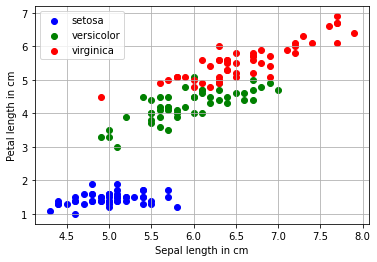

In [4]:
fig, ax = plt.subplots()
# iris type 0
iris0_plt = plt.scatter(x=X[idx_iris1,0], y=X[idx_iris1,2], c='b')
# iris type 1
iris1_plt = plt.scatter(x=X[idx_iris2,0], y=X[idx_iris2,2], c='g')
# iris type 2
iris2_plt = plt.scatter(x=X[idx_iris3,0], y=X[idx_iris3,2], c='r')
plt.xlabel('Sepal length in cm')
plt.ylabel('Petal length in cm')
# flower names are looked up from the target names 
# which are defined in the dataset from load_iris_dataset
# which shall not be modified as mentioned above
ax.legend((iris0_plt, iris1_plt, iris2_plt),('setosa', 'versicolor', 'virginica'))
ax.grid(True)
plt.show()

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [5]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    # generate dataset with both X and y
    D = np.c_[X, y]
    # creating a random order of the dataset's rows by means of shuffling
    np.random.shuffle(D)
    X_shuffled = D[:,range(0,4)]
    y_shuffled = D[:,4]

    # take the first 70% of rows of the randomly shuffled dataset D for training data
    perc_train = int(0.7 * n_samples)
    X_train = X_shuffled[range(perc_train),:]
    y_train = y_shuffled[range(perc_train)]
    # the last 30% that remain is the testing data
    X_test = X_shuffled[range(perc_train, n_samples),:]
    y_test = y_shuffled[range(perc_train, n_samples)]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]


5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [6]:
def minmax_scale_train(X, x_min, x_max):
    # define nominator and denominator for minmax scaling of features
    n = (X-X.min(axis=0))*(x_max-x_min)
    d = X.max(axis=0) - X.min(axis=0)
    # in case of possible zero distance, set d to 1 to prevent division by 0
    d[d==0] = 1
    # calculate scaled version of X
    X_scaled = x_min + n/d
    return X_scaled, X.min(axis=0), X.max(axis=0)

def minmax_scale_test(X, x_min, x_max, X_train_min, X_train_max):
    # similar to the scaling of the training data
    # only difference: testing data needs to scale with min and max of training data!
    n = (X-X_train_min)*(x_max-x_min)
    d = X_train_max - X_train_min
    d[d==0] = 1
    X_scaled = x_min + n/d
    return X_scaled

# calculation of the minmax scaled input features of the dataset
# performed on training and testing data only depending on the information given with the training dataset
X_train_scaled, X_train_min, X_train_max = minmax_scale_train(X_train, 0, 1)
X_test_scaled = minmax_scale_test(X_test, 0 , 1, X_train_min, X_train_max)

## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [ ]:
class KNearestNeighbors(object):
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y
    
    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,k).
        """
        # Implement your solution here.
        pass

    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))

## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [ ]:
def precision(y_pred, y_true):
    # Implement your solution here.
    pass

def recall(y_pred, y_true):
    # Implement your solution here.
    pass

def f1score(y_pred, y_true):
    # Implement your solution here.
    pass

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

In [ ]:
# Implement your solution here.

==> *Write your observations here and report your results.* (double klick here to edit)

3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

==> *Write your response here.* (double klick here to edit)